# Преамбула

В эксперименте мы часто находим расстояние между двумя электронными спинами в интервале 1-8 нм. Для этого мы регистрируем зависимость амплитуды сигнала спинового эха от времени. За счет взаимодействия между спинами эта амплитуда обнаруживает осцилляции. Частота осцилляций определяется величиной взаимодействия, которое зависит от расстояния между спинами. В итоге мы находим нужное расстояние.

В ходе обработки эксперимента мы совершаем Фурье-преобразование. Я предлагаю весь наш протокол работы дополнить еще параллельным шагом. Проведем Фурье-преобразование экспериментальных кривых с помощью квантового Фурье-преобразования. Сравним полученные обычным и квантовым квантовым преобразованием частоты. Мы бы получили опыт реального применения квантового компьютера.

# Генерация данных на классическом компьютере


In [1]:
import numpy as np

low = 1.0
high = 8.0
N = 14


data = low + (high - low) * np.sin(np.linspace(0, 14, N)) + np.random.rand(N)

# Дополнение до степени двойки

Необходимо кубитов: 4


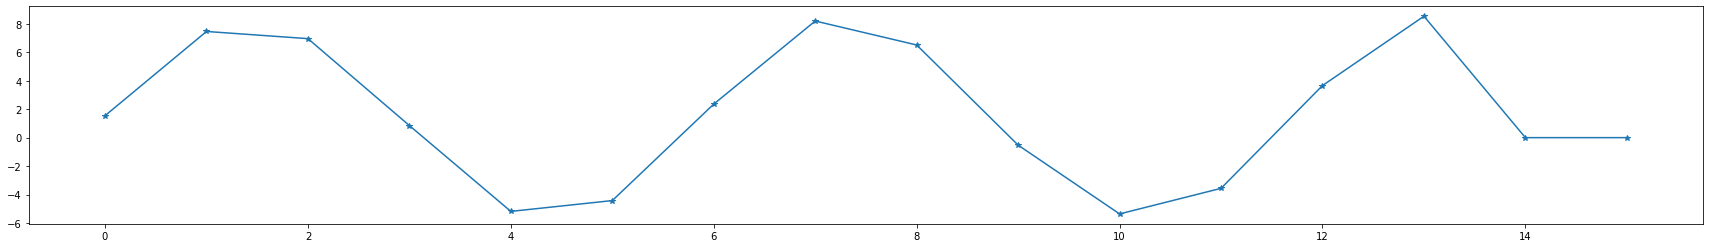

In [2]:
import math
dim = math.ceil(math.log2(len(data)))
data_padded = np.zeros((2 ** dim,))
data_padded[:len(data)] = data

print("Необходимо кубитов:", dim)

import matplotlib.pyplot as plt
plt.figure(figsize=(30, 4))
plt.plot(range(len(data_padded)), data_padded, marker='*')
plt.show()

# Подготовка прогона на симуляторе и реальной машине

In [ ]:
!pip install qiskit pylatexenc

In [3]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit
from qiskit import Aer, execute, IBMQ

from qiskit.visualization import plot_histogram, plot_circuit_layout
import matplotlib.pyplot as plt

# Данные должны быть корректным набором амплитуд квантового состояния

In [4]:
norm = sum([abs(i) ** 2 for i in data_padded]) ** .5
data_normed = data_padded / norm

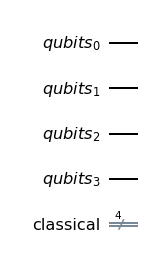

In [5]:
qr = QuantumRegister(dim, name="qubits")
cr = ClassicalRegister(dim, name="classical")
circuit = QuantumCircuit(qr, cr)

circuit.draw(output='mpl')

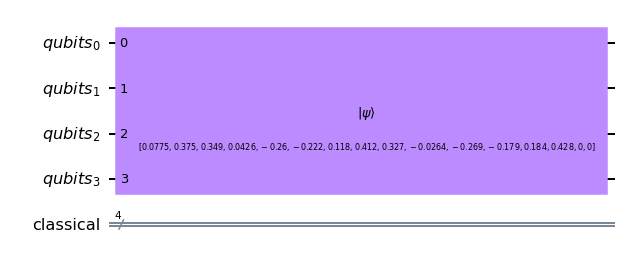

In [6]:
circuit.initialize(data_normed)

circuit.draw(output='mpl')

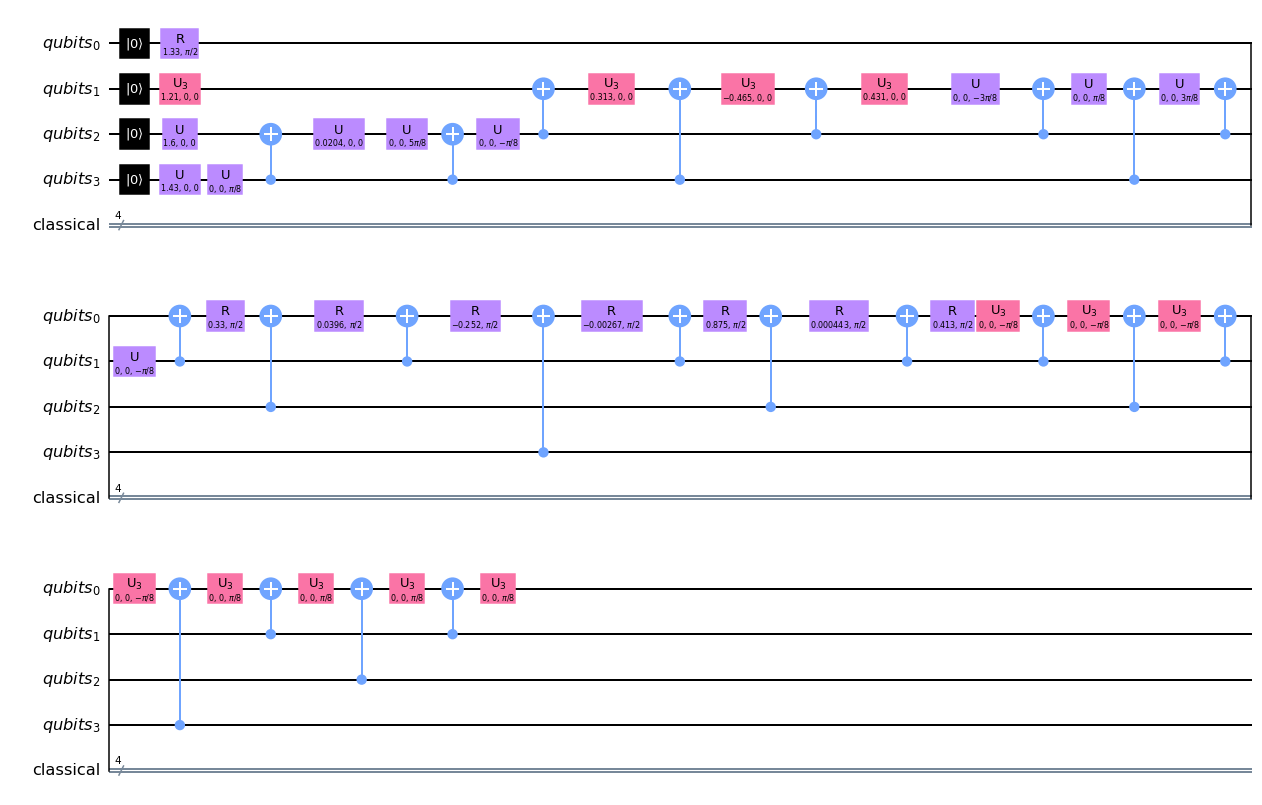

In [7]:
circuit.decompose().decompose().decompose().decompose().decompose().decompose().decompose().draw(output='mpl')

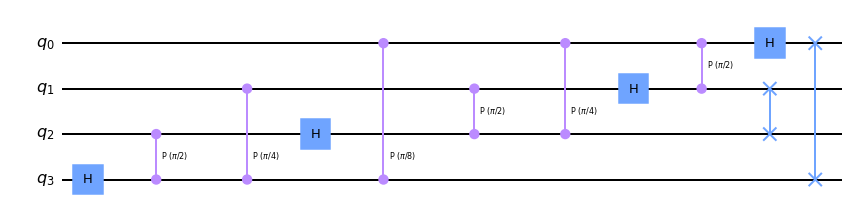

In [8]:
from qiskit.circuit.library import QFT
qft = QFT(dim)
qft.draw(output='mpl')
# print(qc.qasm())

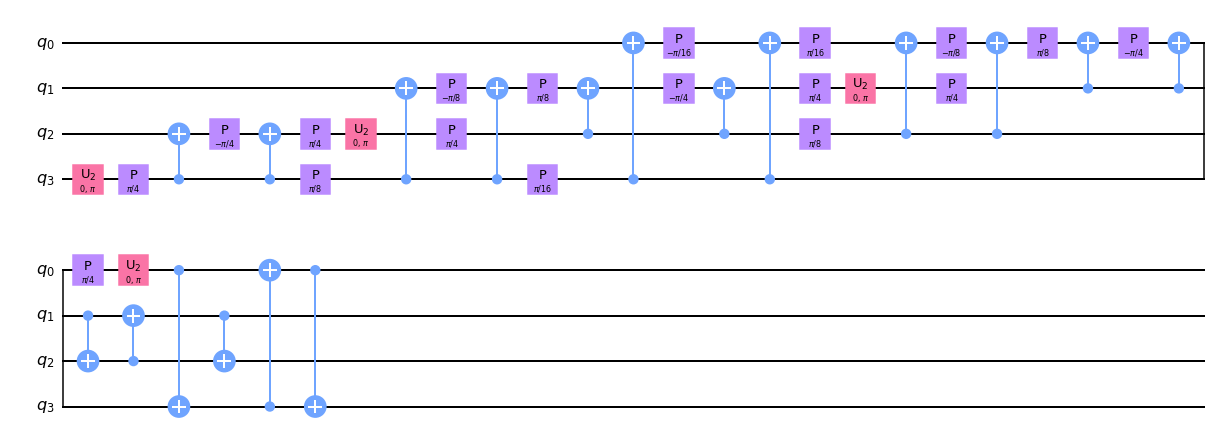

In [9]:
qft.decompose().draw(output='mpl')

In [10]:
print(qft.qasm())

OPENQASM 2.0;
include "qelib1.inc";
qreg q[4];
h q[3];
cp(pi/2) q[3],q[2];
cp(pi/4) q[3],q[1];
cp(pi/8) q[3],q[0];
h q[2];
cp(pi/2) q[2],q[1];
cp(pi/4) q[2],q[0];
h q[1];
cp(pi/2) q[1],q[0];
h q[0];
swap q[0],q[3];
swap q[1],q[2];



# Соберём алгоритм вместе

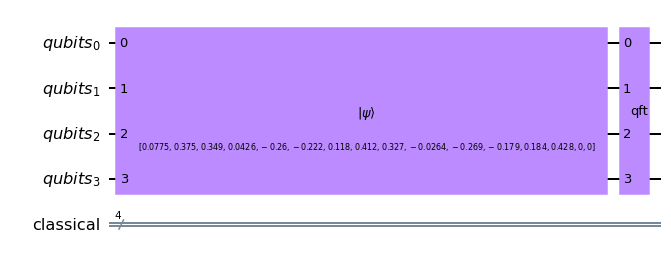

In [11]:
circuit.append(qft, qr)

circuit.draw(output='mpl')

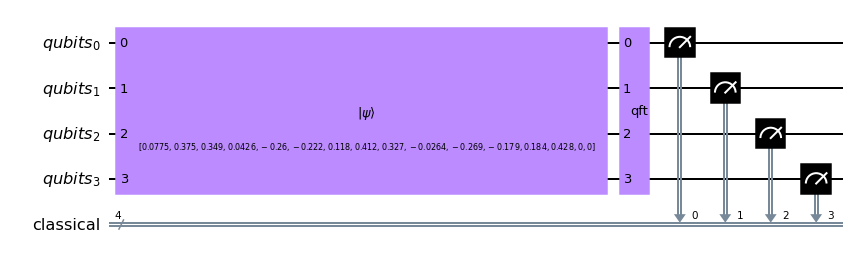

In [12]:
circuit.measure(qr, cr)

circuit.draw(output='mpl')

# Запустим на простейщем классическом вероятностном симуляторе

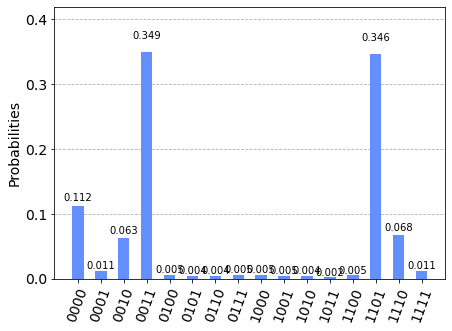

In [13]:
job = execute(circuit, Aer.get_backend('qasm_simulator'), shots=10000)
counts = job.result().get_counts(circuit)
plot_histogram(counts)

In [14]:
l = list((v, int(k, 2)) for k, v in counts.items())
l.sort(reverse=True)
print(l)

[(3486, 3), (3459, 13), (1120, 0), (675, 14), (630, 2), (115, 1), (111, 15), (55, 8), (54, 7), (54, 4), (51, 12), (48, 9), (45, 6), (38, 10), (38, 5), (21, 11)]


# Запустим на настоящем

In [15]:
# IBMQ.save_account(
#     '...'
# )

IBMQ.load_account()

provider = IBMQ.get_provider('ibm-q')


available_cloud_backends = provider.backends() 
for backend in available_cloud_backends:
    status = backend.status()
    nqubits = backend.configuration().n_qubits
    is_operational = status.operational
    jobs_in_queue = status.pending_jobs
    if is_operational and 'ibmq_' in str(backend):
        print(f"{nqubits} Qubits {backend} has a queue={jobs_in_queue}")

32 Qubits ibmq_qasm_simulator has a queue=5
1 Qubits ibmq_armonk has a queue=1
5 Qubits ibmq_bogota has a queue=16
5 Qubits ibmq_lima has a queue=93
5 Qubits ibmq_belem has a queue=75
5 Qubits ibmq_quito has a queue=493
5 Qubits ibmq_manila has a queue=466


In [19]:
qpu = provider.get_backend("ibmq_bogota")

from qiskit.compiler import transpile
circ = transpile(circuit, qpu, optimization_level=2)
print("Depth: ", circ.depth())

Depth:  149


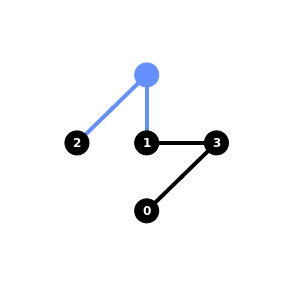

In [20]:
plot_circuit_layout(circ, qpu)

Job Status: job has successfully run


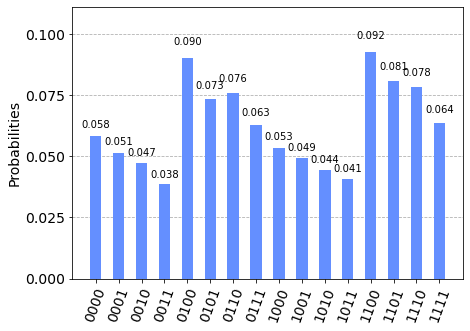

In [21]:
job = execute(circuit, backend=qpu, shots=10000)

from qiskit.tools.monitor import job_monitor

job_monitor(job)
counts = job.result().get_counts()
plot_histogram(counts)

In [22]:
counts

{'0000': 581,
 '0001': 515,
 '0010': 472,
 '0011': 385,
 '0100': 901,
 '0101': 732,
 '0110': 759,
 '0111': 627,
 '1000': 534,
 '1001': 492,
 '1010': 445,
 '1011': 409,
 '1100': 925,
 '1101': 806,
 '1110': 781,
 '1111': 636}